# Spike diversity

author: joseph.tharayil@epfl.ch  
modified: steeve.laquitaine@epfl.ch


method:
* simulate intracellular recording for 16 excitatory cells, 20 inhibitory cells
* electrode site above and below cells
* spike-triggered histogram



activate spikeinterf

## (2s)Setup

In [25]:
# import libs
%load_ext autoreload
%autoreload 2

# import packages
import numpy as np
import matplotlib.pyplot as plt
import bluepy as bp
import h5py
import pandas as pd
import h5py
import os

# PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)
from src.nodes.validation import spikeshape

# DATA PATH
data_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/raw/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/selectedNeurons/pointSource/553a1763-43d5-468b-a211-9a20f647af7a/"

# FIGURE SETTINGS
FIG_SIZE = (1.8, 1.4)
COLOR_HV = [0.3, 0.3, 0.3]
COLOR_HS = np.array([26, 152, 80]) / 255  # green
COLOR_MEDIAN = (1, 0.76, 0)

# axes
# plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5  # 1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5  # 0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5  # 0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5  # 0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5  # 0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent": True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False  # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## (1.5m)Load dataset

In [2]:
# get recorded traces
sim = bp.Simulation(data_path + "0/BlueConfig")
recording = sim.report("lfp")
lfpData = recording.get()

# load spike times
spikeTimes = sim.spikes.get()

# load generative model's weights
file = h5py.File(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/newCoeffs/b3122c45-e2d9-4205-821c-88f28791dc69/0/selectedNeurons/coeffsnearby.h5"
)

electrodeDict = {}
for f_i in file["electrodes"].keys():
    try:
        electrodeDict[f_i] = file["electrodes"][f_i]["offset"][()]
    except:
        pass

lfpDict = {}
for gid in recording.gids:
    try:
        spike = spikeTimes[spikeTimes == gid]
        spike = spike.index[int(len(spike) / 2)]

        startTime = np.argmin(np.abs(lfpData.index - (spike - 5)))
        endTime = np.argmin(np.abs(lfpData.index - (spike + 5)))

        lfpDict[str(gid) + "_above"] = lfpData[gid].iloc[
            startTime:endTime, electrodeDict["nearby_" + str(gid) + "_above"]
        ]
        lfpDict[str(gid) + "_below"] = lfpData[gid].iloc[
            startTime:endTime, electrodeDict["nearby_" + str(gid) + "_below"]
        ]
    except:
        pass

# get inhibitory and excitatory cells
gids = []
inh_gids = []
exc_gids = []
exc = []
inh = []
for gid in recording.gids:
    try:
        lfpTraces = [lfpDict[str(gid) + "_above"], lfpDict[str(gid) + "_below"]]
    except:
        continue

    # record gid
    gids.append(gid)

    # get synaptic type
    synapseClass = sim.circuit.cells.get(gid, properties=[bp.Cell.SYNAPSE_CLASS])[
        "synapse_class"
    ]
    # get inhibitory cell traces
    if synapseClass == "INH":
        inh.append(lfpTraces)
        inh_gids.append(gid)
    elif synapseClass == "EXC":
        # get excitatory cell traces
        exc.append(lfpTraces)
        exc_gids.append(gid)
    else:
        raise ValueError("Weird synapse class value")

# unit-test
assert len(gids) == len(exc) + len(inh)

Have keys ({'desired_unconnected_fr_L1I', 'desired_connected_fr_L5E', 'desired_connected_proportion_of_invivo_frs', 'desired_connected_fr_L4I', 'desired_connected_fr_L5I', 'desired_unconnected_fr_L5E', 'desired_connected_fr_L1I', 'desired_connected_fr_L6E', 'desired_connected_fr_L23I', 'desired_connected_fr_L6I', 'desired_connected_fr_L4E', 'desired_unconnected_fr_L6I', 'desired_unconnected_fr_L5I', 'LFPWeightsPath', 'desired_unconnected_fr_L4I', 'desired_connected_fr_L23E', 'desired_unconnected_fr_L23I', 'depol_stdev_mean_ratio', 'desired_unconnected_fr_L6E', 'desired_unconnected_fr_L23E', 'desired_unconnected_fr_L4E'}) that are not defined for section: Run
Ignoring unknown key: 'LFPWeightsPath'
Ignoring unknown key: 'depol_stdev_mean_ratio'
Ignoring unknown key: 'desired_connected_proportion_of_invivo_frs'
Ignoring unknown key: 'desired_unconnected_fr_L1I'
Ignoring unknown key: 'desired_unconnected_fr_L23E'
Ignoring unknown key: 'desired_unconnected_fr_L23I'
Ignoring unknown key: 'de

In [3]:
# print total unit count
print(len(recording.gids))

# print selected unit count
print(len(gids))

45
36


## Inhibitory cells

In [4]:
inh_mtypes = sim.circuit.cells.get(inh_gids, properties=[bp.Cell.MTYPE])["mtype"]
print("number of inhibitory cells:", len(inh))

number of inhibitory cells: 20


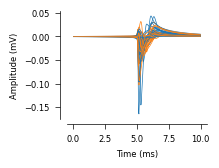

In [5]:
# inhibitory cells
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

for traces in inh:
    time = traces[0].index - np.min(traces[0].index)

    # electrode site above cell
    ax.plot(time, traces[0].values, c="tab:blue")

    # electrode site below cell
    ax.plot(time, traces[1].values, c="tab:orange")

ax.legend(["Above", "Below"])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Amplitude (mV)")

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

## Excitatory cells


In [6]:
print(len(exc))

16


Text(0, 0.5, 'Amplitude (mV)')

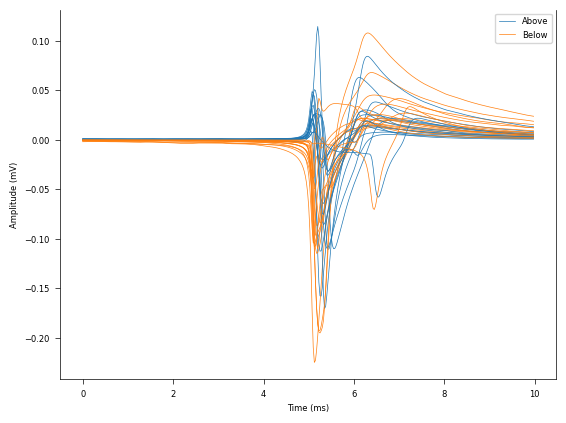

In [7]:
plt.figure()
for traces in exc:
    time = traces[0].index - np.min(traces[0].index)
    plt.plot(time, traces[0].values, c="tab:blue")
    plt.plot(time, traces[1].values, c="tab:orange")

plt.legend(["Above", "Below"])
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (mV)")

## Plot max firing exc. mtypes

In [8]:
exc_mtypes = np.array(
    sim.circuit.cells.get(exc_gids, properties=[bp.Cell.MTYPE])["mtype"]
)

In [17]:
sample_by_ms = 40
before_ms = 1  # total period of 8 ms
after_ms = 3  # total period of 8 ms
ttp_sample = 200  # timestamp index
spike_start = ttp_sample - before_ms * sample_by_ms
spike_end = ttp_sample + after_ms * sample_by_ms

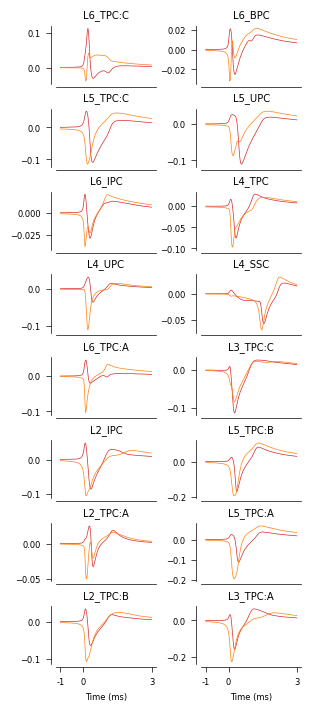

In [30]:
# plot
order = [11, 2, 3, 13, 10, 6, 15, 8, 5, 7, 12, 14, 9, 4, 1, 0]
fig = spikeshape.plot_exc_spikes(
    traces,
    time,
    exc,
    exc_mtypes,
    order,
    ttp_sample,
    spike_start,
    spike_end,
    before_ms,
    after_ms,
    8,
    2,
    (3, 7),
    tight_layout_cfg,
)

# save figures
plt.savefig(
    "figures/6_supp/fig3/fig3A_spikes_ex_mtypes.svg", bbox_inches="tight", **savefig_cfg
)

## Plot max firing inh mtypes

In [27]:
inh_mtypes = np.array(
    sim.circuit.cells.get(inh_gids, properties=[bp.Cell.MTYPE])["mtype"]
)

In [32]:
order = np.arange(0, 20, 1).tolist()
n_rows = 10
n_cols = 2

fig = spikeshape.plot_inh_spikes(
    traces,
    time,
    inh,
    inh_mtypes,
    order,
    ttp_sample,
    spike_start,
    spike_end,
    before_ms,
    after_ms,
    10,
    2,
    (3, 7),
    tight_layout_cfg,
)

# save figures
plt.savefig(
    "figures/6_supp/fig3/fig3B_spikes_inh_mtypes.svg",
    bbox_inches="tight",
    **savefig_cfg
)